### Paola Della Foglia matr. 961014

# <span style="color:red"> Esercitazione numerica 7</span>

## <span style="color:blue"> Esercizio 7.1</span>
### Scopo
Lo scopo dell'esercizio è fare delle simulazioni dello stesso sistema utilizzato nell'esercitazione 4, ma anzichè lavorare nel microcanonico della dinamica molecolare (vedi ex 4), lavoreremo nel canonico implementando il codice Monte Carlo NVT con l'algoritmo di Metropolis.
Quindi invece di produrre configurazioni risolvendo le equazioni del moto a energia costante (ex.4), qui saremo a temperatura costante e genereremo configurazioni campionando una catena di Markov adeguata ad ottenere il campionamento del peso statistico di Boltzmann.

Il codice Monte Carlo NVT stampa i valori istantanei di Energia potenziale per particella $U/N$, e pressione $P$, lungo simulazioni di Monte Carlo equilibrate prima (di $𝑀 = 5*10^5$ passi MC e dove il rapporto di accettazione di Metropolis è stato fissato approssimativamente al 50%) nelle seguenti condizioni termodinamiche:
- fase solida di Lennard-Jones: $\rho^\star = 1.1$, $T^\star = 0.8$, $\delta=0.1$ (cut-off raggio: $r_c = 2.2$)
- fase liquida di Lennard-Jones: $\rho^\star = 0.8$, $T^\star = 1.1$, $\delta=0.2$ (cut-off raggio: $r_c = 2.5$)
- fase gassosa di Lennard-Jones: $\rho^\star = 0.05$, $T^\star = 1.2$, $\delta=6.0$ (cut-off raggio: $r_c = 5.0$)

### Compilazione
Il codice è salvato nella cartella <font face = "Courier"> ex07.1 </font>. Per compilarlo, occorre digitare da shell unix, il comando <font face = "Courier"> `$make` </font> e per eseguirlo il comando <font face = "Courier"> `$./Monte_Carlo_NVT.exe` </font>. 
Nel file <font face = "Courier"> 'input.dat' </font> è possibile settare la temperatura, il numero di particelle, la densità, il raggio di cut-off, delta, il numero di blocchi e nstep il numero totale di steps della simulazione.
In output, dopo aver eseguito la simulazione, otterremo 4 files. 

Dopo aver equilibrato il sistema si esegue la simulazione per $M=5*10^5$ steps, si salvano i valori istantanei di Energia potenziale e pressione.
Di seguito sono riportati i risultati per un solido di Lennard-Jones.

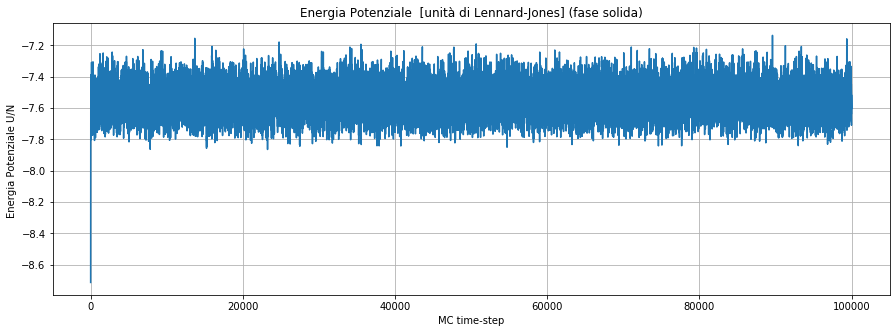

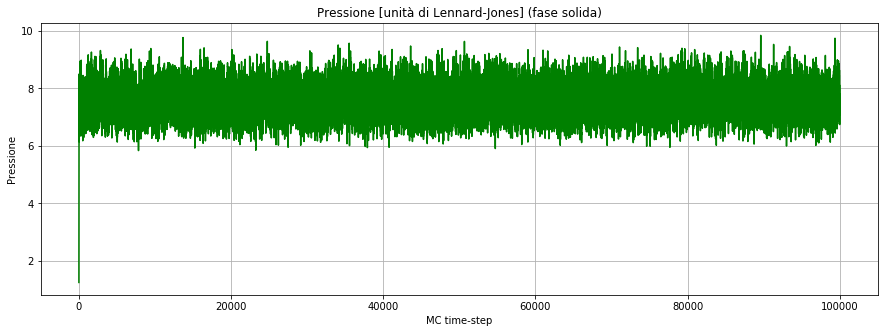

In [28]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

En = np.loadtxt("ex07.1/solido/Potentialenergy.dat", usecols=(0), unpack='true')
Pr = np.loadtxt("ex07.1/solido/Pression.dat", usecols=(0), unpack='true')
plt.plot(En)
plt.xlabel('MC time-step')
plt.ylabel('Energia Potenziale U/N ')
plt.grid(True)
plt.title("Energia Potenziale  [unità di Lennard-Jones] (fase solida)")
plt.show()

plt.plot(Pr, color='green')
plt.xlabel('MC time-step')
plt.ylabel('Pressione')
plt.grid(True)
plt.title("Pressione [unità di Lennard-Jones] (fase solida)")
plt.show()

Nota: I valori istantanei di Energia potenziale e pressione per particella oscillano attorno ai loro valori medi.

#### Funzione di autocorrelazione
La funzione di autocorrelazione è definita nel modo seguente:

$$
\chi(t) = \frac{\langle m(t')m(t+t')\rangle_{t'} -\langle m \rangle^2}{\sigma_m^2}
$$

Per disegnare tale funzione calcoliamo prima il valor medio e la varianza rispettivamente per le due grandezze energia potenziale e pressione per particella.

In [29]:
#AUTOCORRELATION FUNCTION
#Calculating it for time from 0 to 5000
energy_mean = 0
energy_square = 0
pression_mean = 0
pression_square = 0
for i in range (0,100000):
    energy_mean += En[i]
    energy_square += En[i]**2
    pression_mean += Pr[i]
    pression_square += Pr[i]**2
    
energy_mean /= 100000
pression_mean /= 100000

energy_square /= 100000
pression_square /= 100000

energy_variance = energy_square - energy_mean**2
pression_variance = pression_square - pression_mean**2

print("Energia Potenziale (fase solida)")
print("Valor medio : " + str(energy_mean))
print("Varianza   : " + str(energy_variance) + "\n")
print("Pressione (fase solida)")
print("Valor medio : " + str(pression_mean))
print("Varianza : " + str(pression_variance))

Energia Potenziale (fase solida)
Valor medio : -7.546775194600066
Varianza   : 0.00791615906690879

Pressione (fase solida)
Valor medio : 7.59251287930018
Varianza : 0.24307021370893267


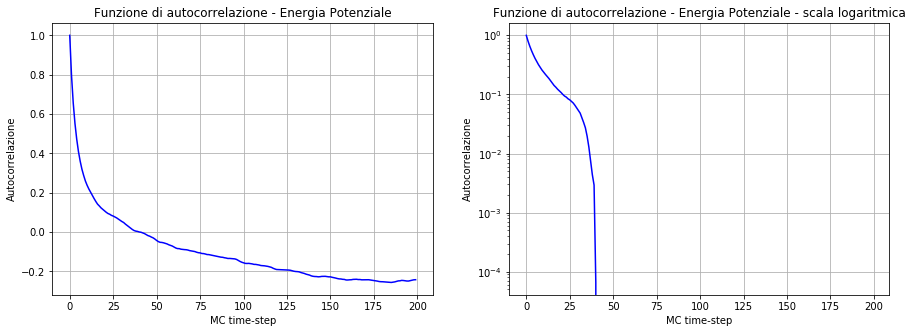

In [55]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [15, 5]
AC_energy = []
for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += En[j] * En[i+j]
        count+=1
    mean_tmp /= count
    AC_energy.append( (mean_tmp - energy_mean**2) / energy_variance )
        
ax[0].plot(AC_energy, color='blue')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione di autocorrelazione - Energia Potenziale")

ax[1].plot(AC_energy, color='blue')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione di autocorrelazione - Energia Potenziale - scala logaritmica")
plt.show()       

La funzione di autocorrelazione ha un andamento che segue un decadimento esponenziale quindi cercheremo di fittarla usando una funzione di questo genere:

$$
\chi(t) = e^{-\frac{t}{t_c}}
$$

$t_c$ corrisponde al tempo di correlazione, ossia il tempo in cui le configurazioni campionate con il Metropolis impiegano a scorrelarsi una dall'altra: dopo un tempo $2t_c$ i valori istantanei sono scorrelati.

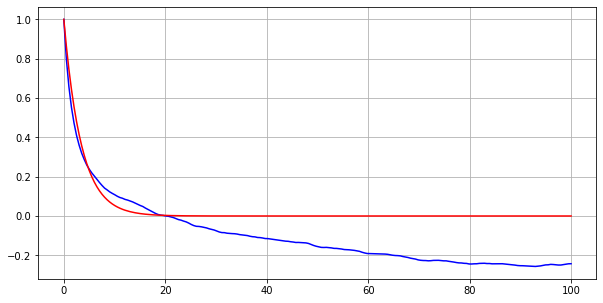

Best fit is f(t) = exp(-t/ 3.421243253239502  )


In [58]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0, 100, 200)

#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_energy)
plt.plot(x, AC_energy, color='blue')
x = np.asarray(x)
plt.plot(x, f(x, *popt), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

Nota: la curva blu rappresenta la funzione di autocorrelazione (già riportata nel grafico precedente), mentre la curva rossa ( curva di FIT) rappresenta la curva che meglio approssima la curva di autocorrelazione.
Quindi il tempo di correlazione è circa $t_c\sim 3,4 s$

Possiamo calcolare la funzione di autocorrelazione anche per la pressione:

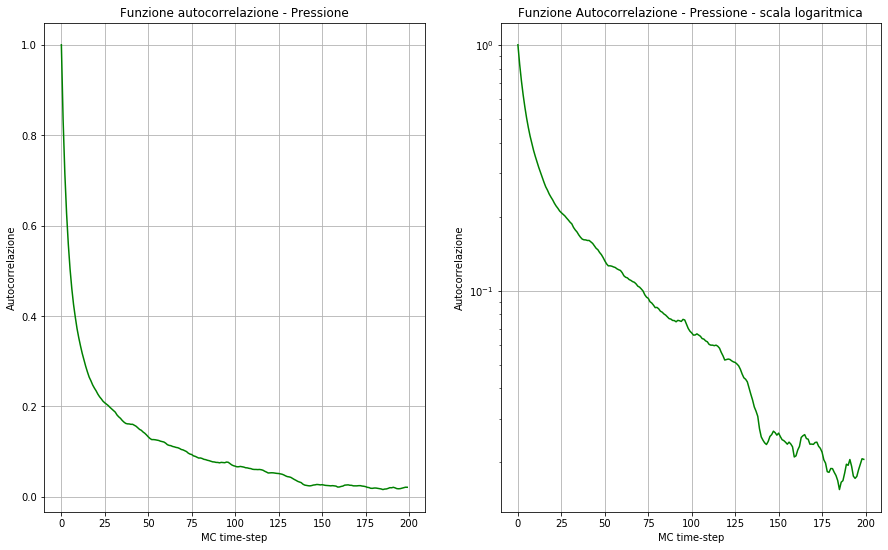

In [29]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [15,9]

AC_pression = []

for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += Pr[j] * Pr[i+j]
        count+=1
    mean_tmp /= count
    AC_pression.append( (mean_tmp - pression_mean**2) / pression_variance )
        
ax[0].plot(AC_pression, color='green')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione autocorrelazione - Pressione")

ax[1].plot(AC_pression, color='green')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione Autocorrelazione - Pressione - scala logaritmica")
plt.show()       

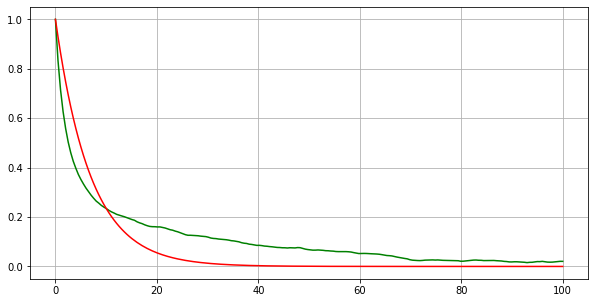

Best fit is f(t) = exp(-t/ 6.904620462519359  )


In [60]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0,100,200)
#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_pression)
plt.plot(x, AC_pression, color='green')
x = np.asarray(x)
plt.plot(x , f(x, popt[0]), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

In questo caso il tempo di correlazione è : $t_c\sim7 s$

Possiamo procedere a calcolare la funzione di autocorrelazione per la fase liquida e gassosa. 

### Fase liquida

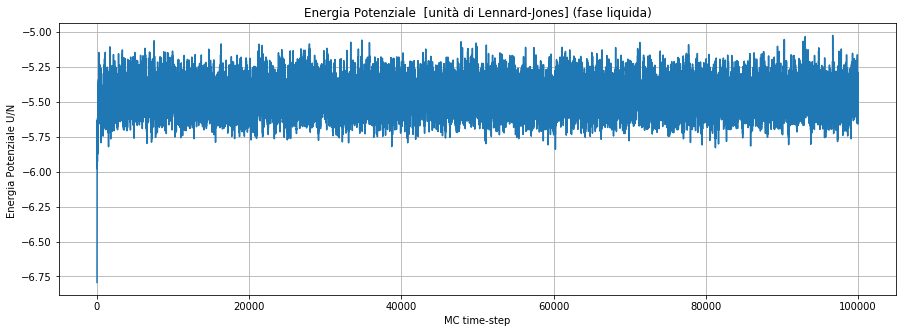

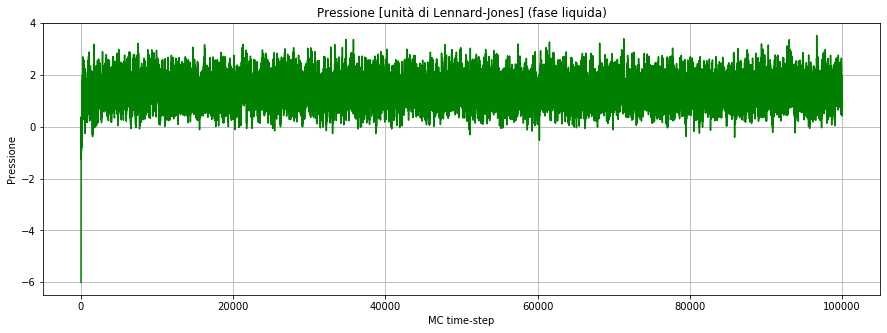

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

En = np.loadtxt("ex07.1/liquido/Potentialenergy.dat", usecols=(0), unpack='true')
Pr = np.loadtxt("ex07.1/liquido/Pression.dat", usecols=(0), unpack='true')
plt.plot(En)
plt.xlabel('MC time-step')
plt.ylabel('Energia Potenziale U/N ')
plt.grid(True)
plt.title("Energia Potenziale  [unità di Lennard-Jones] (fase liquida)")
plt.show()

plt.plot(Pr, color='green')
plt.xlabel('MC time-step')
plt.ylabel('Pressione')
plt.grid(True)
plt.title("Pressione [unità di Lennard-Jones] (fase liquida)")
plt.show()

In [7]:
#AUTOCORRELATION FUNCTION
#Calculating it for time from 0 to 5000
energy_mean = 0
energy_square = 0
pression_mean = 0
pression_square = 0
for i in range (0,100000):
    energy_mean += En[i]
    energy_square += En[i]**2
    pression_mean += Pr[i]
    pression_square += Pr[i]**2
    
energy_mean /= 100000
pression_mean /= 100000

energy_square /= 100000
pression_square /= 100000

energy_variance = energy_square - energy_mean**2
pression_variance = pression_square - pression_mean**2

print("Energia Potenziale (fase liquida)")
print("Valor medio : " + str(energy_mean))
print("Varianza   : " + str(energy_variance) + "\n")
print("Pressione (fase liquida)")
print("Valor medio : " + str(pression_mean))
print("Varianza : " + str(pression_variance))

Energia Potenziale (fase liquida)
Valor medio : -5.466867020299933
Varianza   : 0.009767526795180004

Pressione (fase liquida)
Valor medio : 1.3861662748424046
Varianza : 0.22220873211322711


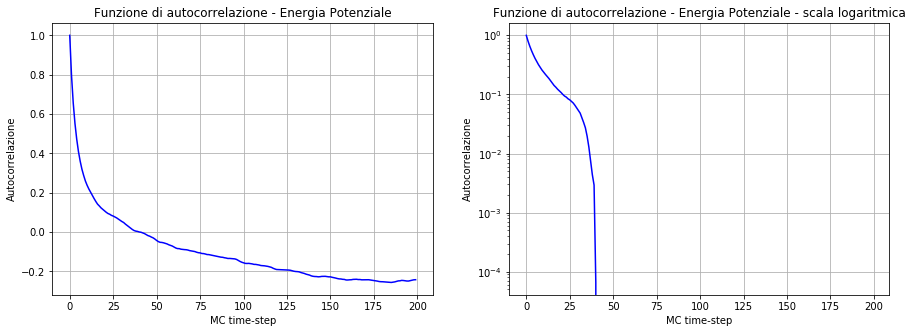

In [20]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [10,5]
AC_energy = []
for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += En[j] * En[i+j]
        count+=1
    mean_tmp /= count
    AC_energy.append( (mean_tmp - energy_mean**2) / energy_variance )
        
ax[0].plot(AC_energy, color='blue')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione di autocorrelazione - Energia Potenziale")

ax[1].plot(AC_energy, color='blue')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione di autocorrelazione - Energia Potenziale - scala logaritmica")
plt.show()       

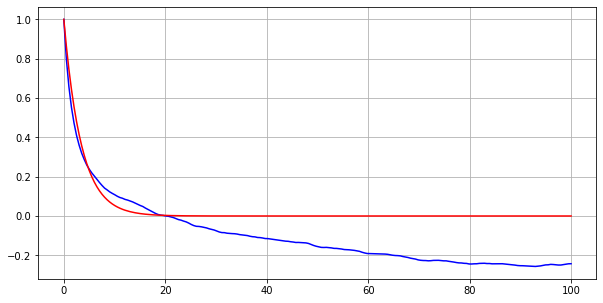

Best fit is f(t) = exp(-t/ 3.421243253239502  )


In [31]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0, 100, 200)

#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_energy)
plt.plot(x, AC_energy, color='blue')
x = np.asarray(x)
plt.plot(x, f(x, *popt), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

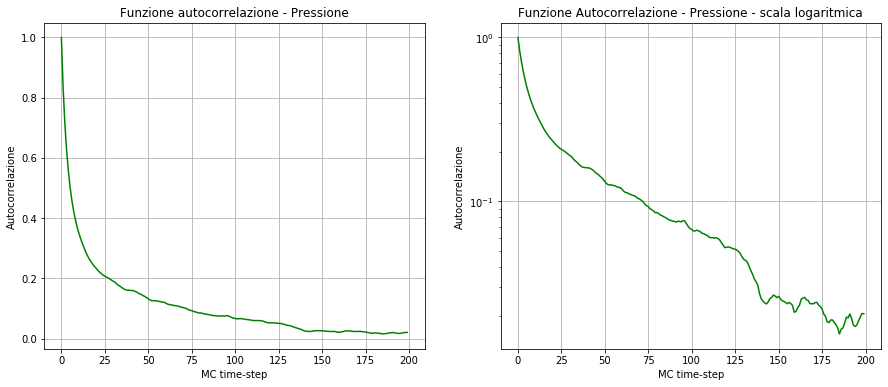

In [28]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [15,9]

AC_pression = []

for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += Pr[j] * Pr[i+j]
        count+=1
    mean_tmp /= count
    AC_pression.append( (mean_tmp - pression_mean**2) / pression_variance )
        
ax[0].plot(AC_pression, color='green')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione autocorrelazione - Pressione")

ax[1].plot(AC_pression, color='green')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione Autocorrelazione - Pressione - scala logaritmica")
plt.show()       

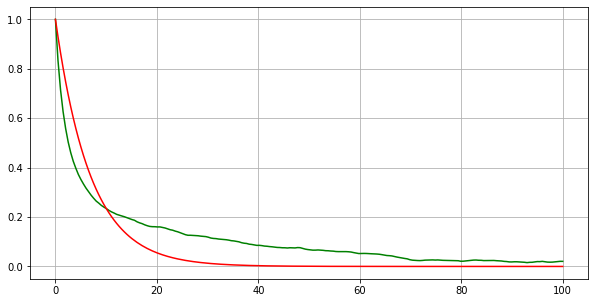

Best fit is f(t) = exp(-t/ 6.904620462519359  )


In [30]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0,100,200)
#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_pression)
plt.plot(x, AC_pression, color='green')
x = np.asarray(x)
plt.plot(x , f(x, popt[0]), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

### Fase gassosa

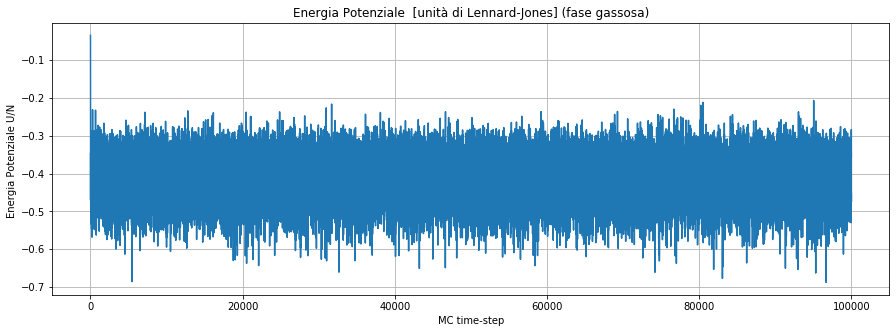

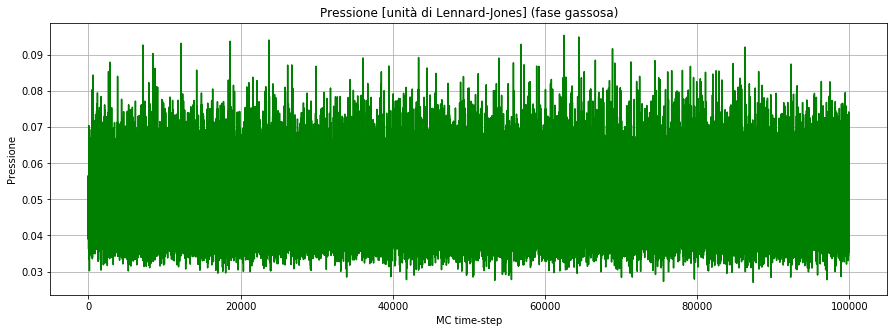

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

En = np.loadtxt("ex07.1/gas/Potentialenergy.dat", usecols=(0), unpack='true')
Pr = np.loadtxt("ex07.1/gas/Pression.dat", usecols=(0), unpack='true')
plt.plot(En)
plt.xlabel('MC time-step')
plt.ylabel('Energia Potenziale U/N ')
plt.grid(True)
plt.title("Energia Potenziale  [unità di Lennard-Jones] (fase gassosa)")
plt.show()

plt.plot(Pr, color='green')
plt.xlabel('MC time-step')
plt.ylabel('Pressione')
plt.grid(True)
plt.title("Pressione [unità di Lennard-Jones] (fase gassosa)")
plt.show()

In [36]:
#AUTOCORRELATION FUNCTION
#Calculating it for time from 0 to 5000
energy_mean = 0
energy_square = 0
pression_mean = 0
pression_square = 0
for i in range (0,100000):
    energy_mean += En[i]
    energy_square += En[i]**2
    pression_mean += Pr[i]
    pression_square += Pr[i]**2
    
energy_mean /= 100000
pression_mean /= 100000

energy_square /= 100000
pression_square /= 100000

energy_variance = energy_square - energy_mean**2
pression_variance = pression_square - pression_mean**2

print("Energia Potenziale (fase gassosa)")
print("Valor medio : " + str(energy_mean))
print("Varianza   : " + str(energy_variance) + "\n")
print("Pressione (fase gassosa)")
print("Valor medio : " + str(pression_mean))
print("Varianza : " + str(pression_variance))

Energia Potenziale (fase gassosa)
Valor medio : -0.414031756571998
Varianza   : 0.002684593213250791

Pressione (fase gassosa)
Valor medio : 0.04901050335800034
Varianza : 6.153374643956891e-05


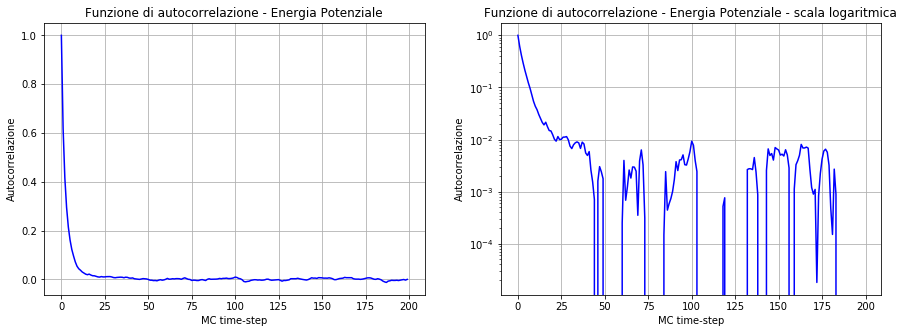

In [37]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [10,5]
AC_energy = []
for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += En[j] * En[i+j]
        count+=1
    mean_tmp /= count
    AC_energy.append( (mean_tmp - energy_mean**2) / energy_variance )
        
ax[0].plot(AC_energy, color='blue')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione di autocorrelazione - Energia Potenziale")

ax[1].plot(AC_energy, color='blue')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione di autocorrelazione - Energia Potenziale - scala logaritmica")
plt.show()       

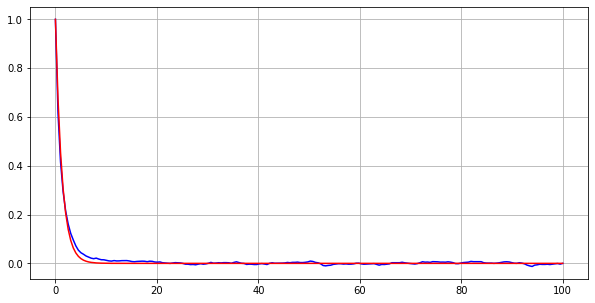

Best fit is f(t) = exp(-t/ 1.2748800875047643  )


In [38]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0, 100, 200)

#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_energy)
plt.plot(x, AC_energy, color='blue')
x = np.asarray(x)
plt.plot(x, f(x, *popt), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

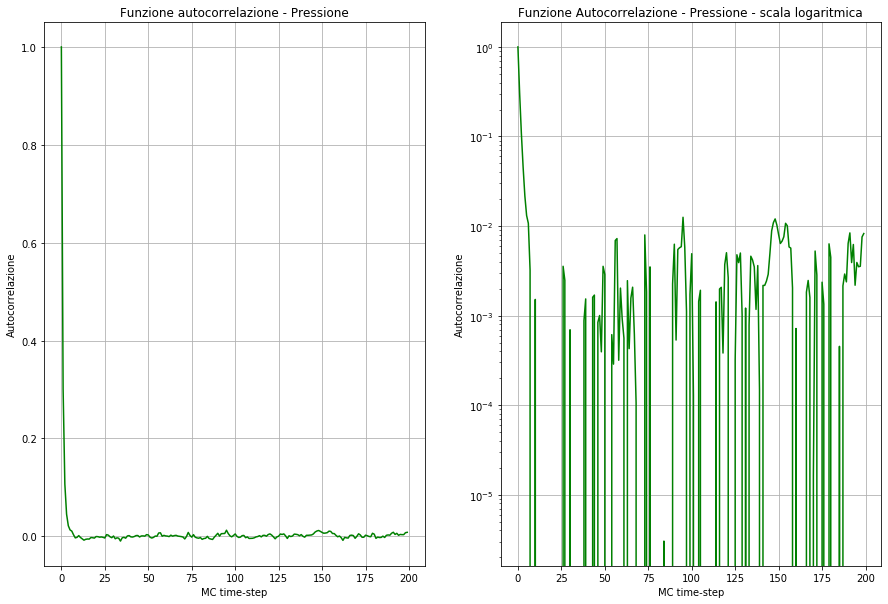

In [52]:
fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [15,9]

AC_pression = []

for i in range(0,200):
    mean_tmp = 0.
    count = 0
    for j in range (0,100000-i):
        mean_tmp += Pr[j] * Pr[i+j]
        count+=1
    mean_tmp /= count
    AC_pression.append( (mean_tmp - pression_mean**2) / pression_variance )
        
ax[0].plot(AC_pression, color='green')
ax[0].set_xlabel('MC time-step')
ax[0].set_ylabel('Autocorrelazione')
ax[0].grid(True)
ax[0].set_title("Funzione autocorrelazione - Pressione")

ax[1].plot(AC_pression, color='green')
ax[1].set_xlabel('MC time-step')
ax[1].set_ylabel('Autocorrelazione')
ax[1].set_yscale('log')
ax[1].grid(True)
ax[1].set_title("Funzione Autocorrelazione - Pressione - scala logaritmica")
plt.show()       

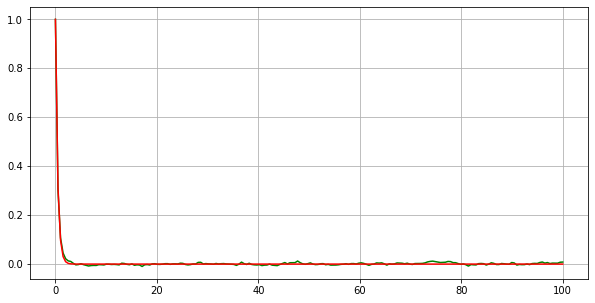

Best fit is f(t) = exp(-t/ 0.4326065047210394  )


In [45]:
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = [10, 5]

x=np.linspace(0,100,200)
#try to fit f(N)= EXP(-x/a)
def f (x, a):
    return np.exp(-x/a) 

popt, pcov = curve_fit(f, x, AC_pression)
plt.plot(x, AC_pression, color='green')
x = np.asarray(x)
plt.plot(x , f(x, popt[0]), 'r')
plt.grid(True)
plt.show()
print('Best fit is f(t) = exp(-t/', popt[0], ' )' )

Ricapitolando abbiamo ottenuto i seguenti risultati:
###### Fase solida
Tempo di correlazione per l'energia potenziale -> 3,4 s

Tempo di correlazione per la pressione -> 6,7 s

###### Fase liquida
Tempo di correlazione per l'energia potenziale -> 3,4 s

Tempo di correlazione per la pressione -> 6,9 s

###### Fase gassosa
Tempo di correlazione per l'energia potenziale -> 1,27 s

Tempo di correlazione per la pressione -> 0,43 s


Utilizzeremo questi dati per studiare come le incertezze statistiche sul valore di aspettazione di $U/N$ e di $P$ dipendono dalla dimensione dei blocchi.
Con il metodo della "media a blocchi" partiamo da $L=M/N=10$ a $L=5\times 10^3$, ogni 10 step, con $N$ il numero dei blocchi .

Per far ciò abbiamo elaborato uno script in Python che divide i valori istantanei di energia potenziale per particella e pressione in $N$ blocchi di dimensione $L$ e calcola le incertezze statistiche sul valore di aspettazione. 
Esso ripete il calcolo a partire da $L$=$10$ fino a $L$=$5\times10^3$ ogni $10$ step: i risultati sono riportati sotto:

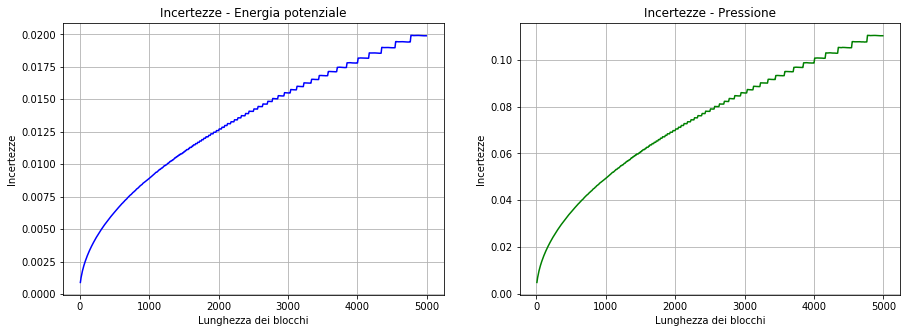

In [68]:
L_min = 10
L_max = 5000
L_step = 10
n_step = int((L_max-L_min)/L_step)
x_error = np.zeros(n_step)
y_error_en = np.zeros(n_step)
y_error_pr = np.zeros(n_step)

#cycle for different values of L
for index in range (n_step):
    L = L_min + index*L_step
    n_block = int(100000/L)
    en_mean_L    = 0.
    en_mean_sq_L = 0.
    pr_mean_L    = 0.
    pr_mean_sq_L = 0.
    
    #cycle for blocks
    for i in range (int(n_block)):
        en_mean_bl    = 0.
        en_mean_sq_bl = 0.
        pr_mean_bl    = 0.
        pr_mean_sq_bl = 0.
        count = 0
        #cycle for values inside block
        for j in range (L):
            count += 1
            en_mean_bl    += En[i*L+j]
            en_mean_sq_bl += En[i*L+j]**2
            pr_mean_bl    += Pr[i*L+j]
            pr_mean_sq_bl += Pr[i*L+j]**2

        en_mean_bl    /= count
        en_mean_sq_bl /= count
        
        pr_mean_bl    /= count
        pr_mean_sq_bl /= count


        en_mean_L += en_mean_bl
        en_mean_sq_L += en_mean_sq_bl
        pr_mean_L += pr_mean_bl
        pr_mean_sq_L += pr_mean_sq_bl

    en_mean_L /= n_block
    en_mean_sq_L /= n_block
    
    pr_mean_L /= n_block
    pr_mean_sq_L /= n_block

    x_error[index] = L
    y_error_en[index] = np.sqrt( (en_mean_sq_L - en_mean_L**2)/n_block )
    y_error_pr[index] = np.sqrt( (pr_mean_sq_L - pr_mean_L**2)/n_block )

fig, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = [20, 5]

ax[0].plot(x_error, y_error_en, color='blue')
ax[0].set_xlabel('Lunghezza dei blocchi')
ax[0].set_ylabel('Incertezze')
ax[0].grid(True)
ax[0].set_title("Incertezze - Energia potenziale")

ax[1].plot(x_error, y_error_pr, color='green')
ax[1].set_xlabel('Lunghezza dei blocchi')
ax[1].set_ylabel('Incertezze')
ax[1].grid(True)
ax[1].set_title("Incertezze - Pressione")
plt.show()

Abbiamo calcolato le incertezze per ogni valore di L con la formula seguente, dove $N$ è il numero dei blocchi:

$$
\frac{\sigma}{\sqrt{N-1}} \simeq \sqrt{\frac{1}{N-1} \left[ \frac{1}{N} \sum_{i=1}^N En^2_i - \left( \frac{1}{N} \sum_{i=1}^N En_i \right)^2 \right]} 
$$

Dai grafici, riportati sopra si nota che le incertezze statistiche crescono all'aumentare della dimensione dei blocchi, fino a raggiungere un certo valore di saturazione, in cui si stabilizzano. Ciò significa che il blocco è sufficientemente grande e aumentarlo ulteriormente non cambia l'incertezza statistica a parità di dati che generiamo.
Il motivo per cui le incertezze statistiche crescono al crescere della lunghezza dei blocchi è dovuto al fatto che se la lunghezza di un singolo blocco cresce e il numero totale di passi MC rimane lo stesso, il numero di blocchi deve diminuire e quindi l'errore aumenta.
Per avere un errore piccolo la lunghezza dei blocchi deve essere piccola, quindi il numero dei blocchi deve essere maggiore uguale di $2-3 \times t_c$ altrimenti non possiamo utilizzare il CLT (Teorema del limite centrale) e calcolare le incertezze come mostrato nel grafico precedente. 

Nel nostro caso sceglieremo L con i seguenti valori:

##### solido $\to$ 30
##### liquido $\to$ 40
##### gas $\to$ 20

Nella fase gassosa, le posizioni vengono scorrelate in soli 5 mosse perché il parametro $\delta$ dell'algoritmo di Metropolis è $6.0$, mentre il bordo del box di simulazione è $\sim12$. Quando l'algoritmo genera una mossa, ogni particella può finire in qualsiasi posizione del box e la posizione è indipendente dalla precedente.

## <span style="color:blue"> Esercizio 7.2</span>
Implementiamo il calcolo di $g(r)$, ossia la funzione radiale di distribuzione della distanza tra due particelle (anche detta funzione radiale di distribuzione a coppie) per $r \in \left[ 0; L/2\right]$ e plottiamo i risultati sotto:

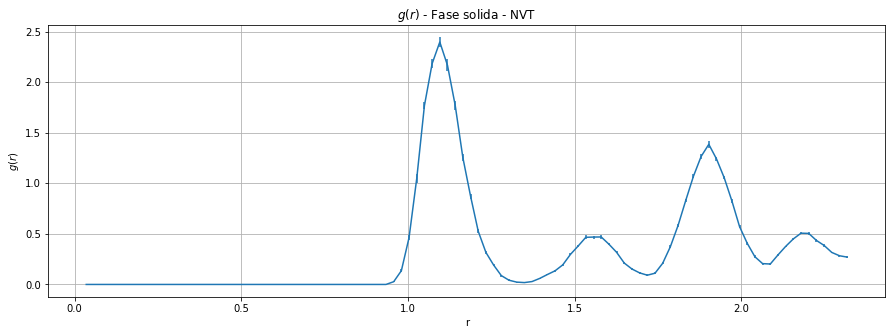

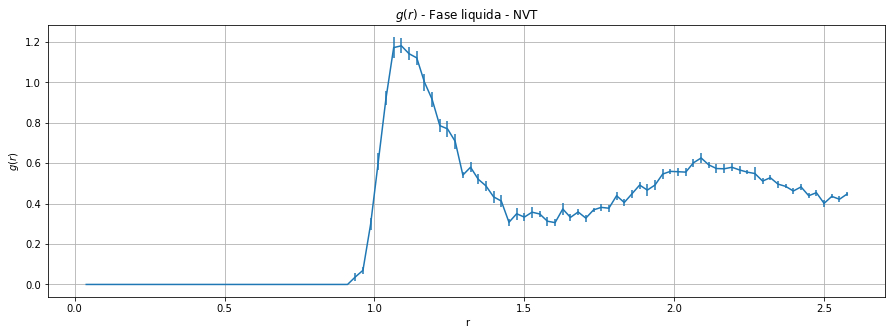

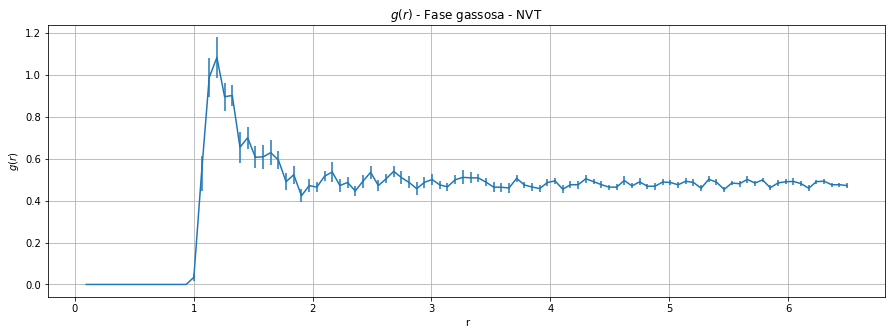

In [70]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

r_solid, gofr_solid, err_g_solid = np.loadtxt("ex07.1/solido/output.gave.0", usecols=(0,1,2), unpack='true')
r_liquid, gofr_liquid, err_g_liquid = np.loadtxt("ex07.1/liquido/output.gave.0", usecols=(0,1,2), unpack='true')
r_gas, gofr_gas, err_g_gas = np.loadtxt("ex07.1/gas/output.gave.0", usecols=(0,1,2), unpack='true')

plt.errorbar(r_solid, gofr_solid, err_g_solid)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase solida - NVT")
plt.show()

plt.errorbar(r_liquid, gofr_liquid, err_g_liquid)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase liquida - NVT")
plt.show()

plt.errorbar(r_gas, gofr_gas, err_g_gas)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase gassosa - NVT")
plt.show()

## <span style="color:blue"> Esercizio 7.3</span>
Di seguito aggiorneremo il codice dell' Esercitazione numerica 4 di Dinamica molecolare, con il calcolo di $g(r)$:

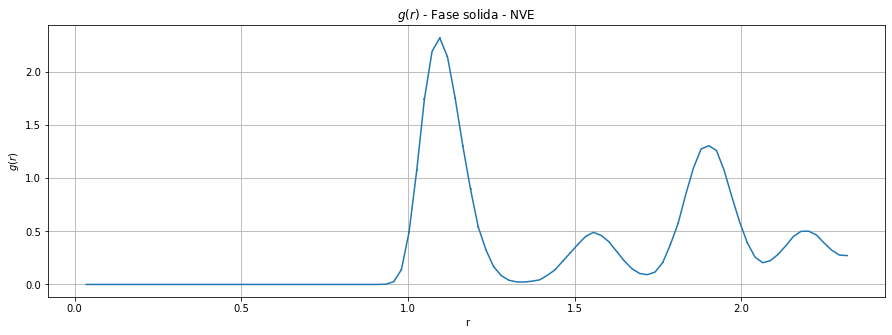

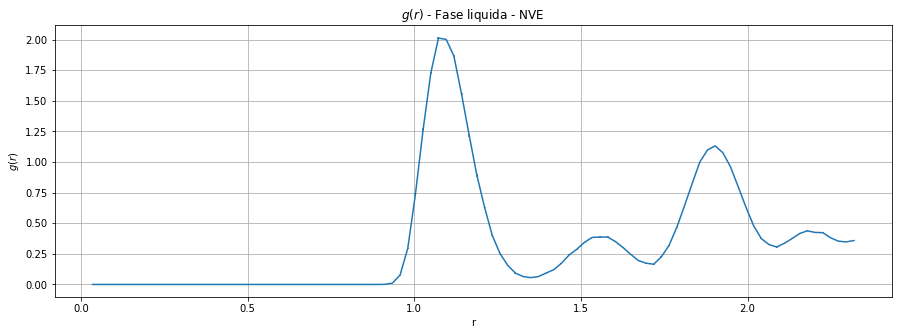

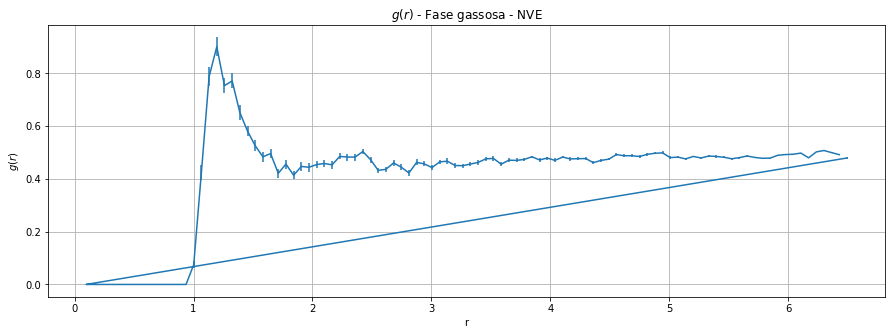

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [15, 5]

r_solid, gofr_solid, err_g_solid = np.loadtxt("../ex4/ex04.1/risultati_solido/output.gave.0", usecols=(0,1,2), unpack='true')
r_liquid, gofr_liquid, err_g_liquid = np.loadtxt("../ex4/ex04.1/risultati_liquido/output.gave.0", usecols=(0,1,2), unpack='true')
r_gas, gofr_gas, err_g_gas = np.loadtxt("../ex4/ex04.1/risultati_gas/output.gave.0", usecols=(0,1,2), unpack='true')

plt.errorbar(r_solid, gofr_solid, err_g_solid)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase solida - NVE")
plt.show()

plt.errorbar(r_liquid, gofr_liquid, err_g_liquid)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase liquida - NVE")
plt.show()

plt.errorbar(r_gas, gofr_gas, err_g_gas)
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.title("$g(r)$ - Fase gassosa - NVE")
plt.show()

I risultati per il calcolo di $g(r)$ nel microcanonico in Dinamica molecolare sono quasi identici a quelli trovati per $g(r)$, che in questo caso è una funzione di distribuzione a coppie, nel canonico ottenute con il codice MC NV.
(Nel grafico della g(r) per la fase gassosa NVE compare una retta che congiunge l'ultimo punto al primo che non dovrebbe comparire).

## <span style="color:blue"> Esercizio 7.4</span>

Eseguiremo ora la simulazione per una scatola contenente particelle di Argon in equilibrio ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle condizioni seguenti:
1. Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off raggio: $r_c = 2.2$)
2. Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off raggio: $r_c = 2.5$)
3. Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off raggio: $r_c = 5.0$)

confronteremo i risultati ottenuti con quelli dell'esercitazione numerica 4 (di dinamica molecolare eseguita con l'algoritmo di Verlet).

Per tutti i grafici riportati in questo punto 4 dell'esercizio mi sono fermata a plottare i valori medi delle varie grandezze fisiche fino a nsteps=20 calcolati con  NVE ed NVT, in quanto nella simulazione NVT ci fermiamo al calcolo del ventesimo blocco.
### Fase solida

I risultati per il calcolo di $g(r)$ nel microcanonico in Dinamica molecolare sono perfettamente sovrapponibili a quelli trovati per $g(r)$, che in questo caso è una funzione di distribuzione a coppie, nel canonico ottenute con il codice MC NV.

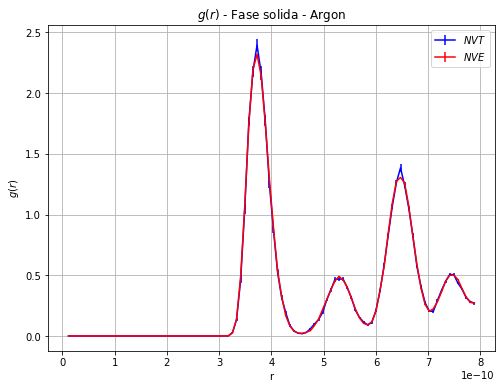

In [127]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

r_solid_NVT, gofr_solid_NVT, err_g_solid_NVT = np.loadtxt("ex07.1/solido/output.gave.0", usecols=(0,1,2), unpack='true')
r_solid_NVE, gofr_solid_NVE, err_g_solid_NVE = np.loadtxt("../ex4/ex04.1/risultati_solido/output.gave.0", usecols=(0,1,2), unpack='true')

plt.errorbar(r_solid_NVT*sigma_arg, gofr_solid_NVT, err_g_solid_NVT, color='blue')
plt.errorbar(r_solid_NVE*sigma_arg, gofr_solid_NVE, err_g_solid_NVE, color='red')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$g(r)$ - Fase solida - Argon")
plt.show()

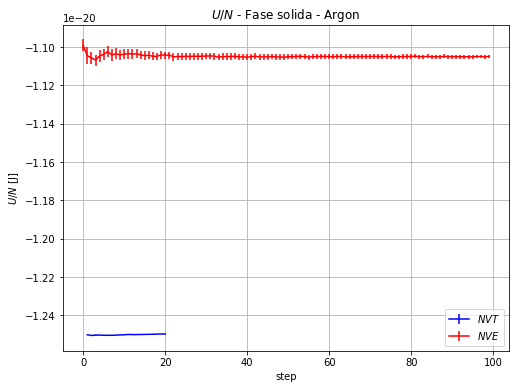

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step_solid_NVT, en_solid_NVT, err_en_solid_NVT  = np.loadtxt("ex07.1/solido/output.epot.0", usecols=(0,2,3), unpack='true')
step_solid_NVE, en_solid_NVE, err_en_solid_NVE = np.loadtxt("../ex4/ex04.1/risultati_solido/output_epot_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step_solid_NVT, en_solid_NVT*eps_arg, yerr=err_en_solid_NVT*eps_arg, color='blue')
plt.errorbar(step_solid_NVE, en_solid_NVE*eps_arg, yerr=err_en_solid_NVE*eps_arg, color='red')
plt.xlabel('step')
plt.ylabel('$U/N$ [J]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$U/N$ - Fase solida - Argon")
plt.show()

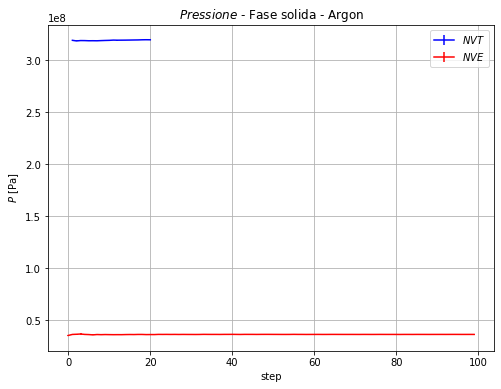

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step2_solid_NVT, pr_solid_NVT, err_pr_solid_NVT  = np.loadtxt("ex07.1/solido/output.pres.0", usecols=(0,2,3), unpack='true')
step2_solid_NVE, pr_solid_NVE, err_pr_solid_NVE = np.loadtxt("../ex4/ex04.1/risultati_solido/output_press_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step2_solid_NVT, pr_solid_NVT*eps_arg/(sigma_arg**3), err_pr_solid_NVT*eps_arg/(sigma_arg**3), color='blue')
plt.errorbar(step2_solid_NVE, pr_solid_NVE*eps_arg/(sigma_arg**3), err_pr_solid_NVE*eps_arg/(sigma_arg**3), color='red')
plt.xlabel('step')
plt.ylabel('$P$ [Pa]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$Pressione$ - Fase solida - Argon")
plt.show()

### Fase liquida

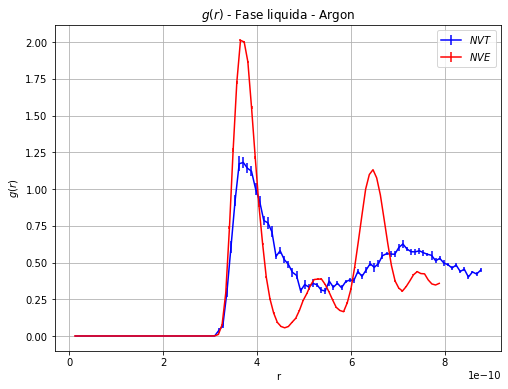

In [119]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

r_liquid_NVT, gofr_liquid_NVT, err_g_liquid_NVT = np.loadtxt("ex07.1/liquido/output.gave.0", usecols=(0,1,2), unpack='true')
r_liquid_NVE, gofr_liquid_NVE, err_g_liquid_NVE = np.loadtxt("../ex4/ex04.1/risultati_liquido/output.gave.0", usecols=(0,1,2), unpack='true')

plt.errorbar(r_liquid_NVT*sigma_arg, gofr_liquid_NVT, err_g_liquid_NVT, color='blue')
plt.errorbar(r_liquid_NVE*sigma_arg, gofr_liquid_NVE, err_g_liquid_NVE, color='red')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$g(r)$ - Fase liquida - Argon")
plt.show()

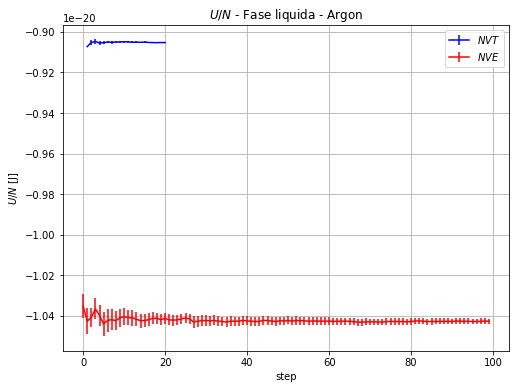

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step_liquid_NVT, en_liquid_NVT, err_en_liquid_NVT  = np.loadtxt("ex07.1/liquido/output.epot.0", usecols=(0,2,3), unpack='true')
step_liquid_NVE, en_liquid_NVE, err_en_liquid_NVE = np.loadtxt("../ex4/ex04.1/risultati_liquido/output_epot_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step_liquid_NVT, en_liquid_NVT*eps_arg, yerr=err_en_liquid_NVT*eps_arg, color='blue')
plt.errorbar(step_liquid_NVE, en_liquid_NVE*eps_arg, yerr=err_en_liquid_NVE*eps_arg, color='red')
plt.xlabel('step')
plt.ylabel('$U/N$ [J]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$U/N$ - Fase liquida - Argon")
plt.show()

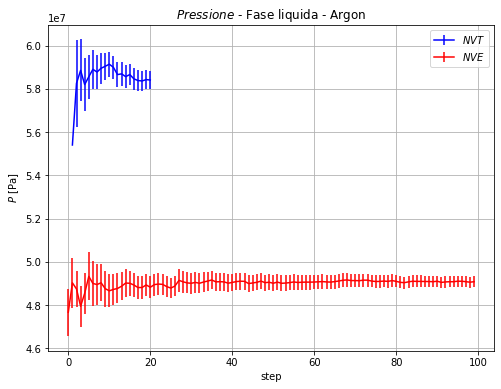

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step2_liquid_NVT, pr_liquid_NVT, err_pr_liquid_NVT  = np.loadtxt("ex07.1/liquido/output.pres.0", usecols=(0,2,3), unpack='true')
step2_liquid_NVE, pr_liquid_NVE, err_pr_liquid_NVE = np.loadtxt("../ex4/ex04.1/risultati_liquido/output_press_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step2_liquid_NVT, pr_liquid_NVT*eps_arg/(sigma_arg**3), err_pr_liquid_NVT*eps_arg/(sigma_arg**3), color='blue')
plt.errorbar(step2_liquid_NVE, pr_liquid_NVE*eps_arg/(sigma_arg**3), err_pr_liquid_NVE*eps_arg/(sigma_arg**3), color='red')
plt.xlabel('step')
plt.ylabel('$P$ [Pa]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$Pressione$ - Fase liquida - Argon")
plt.show()

### Fase gassosa

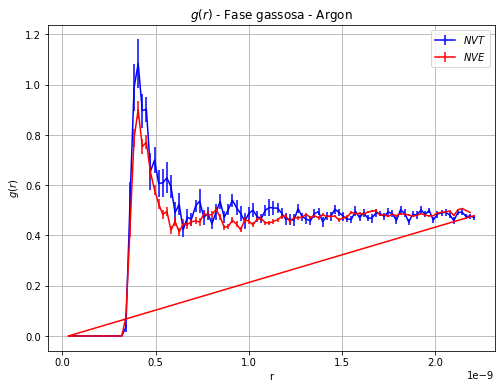

In [124]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

r_gas_NVT, gofr_gas_NVT, err_g_gas_NVT = np.loadtxt("ex07.1/gas/output.gave.0", usecols=(0,1,2), unpack='true')
r_gas_NVE, gofr_gas_NVE, err_g_gas_NVE = np.loadtxt("../ex4/ex04.1/risultati_gas/output.gave.0", usecols=(0,1,2), unpack='true')

plt.errorbar(r_gas_NVT*sigma_arg, gofr_gas_NVT, err_g_gas_NVT, color='blue')
plt.errorbar(r_gas_NVE*sigma_arg, gofr_gas_NVE, err_g_gas_NVE, color='red')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$g(r)$ - Fase gassosa - Argon")
plt.show()

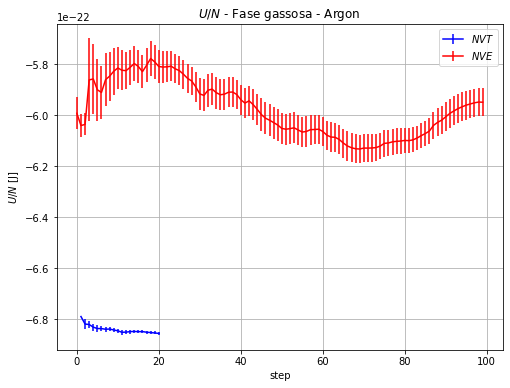

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step_gas_NVT, en_gas_NVT, err_en_gas_NVT  = np.loadtxt("ex07.1/gas/output.epot.0", usecols=(0,2,3), unpack='true')
step_gas_NVE, en_gas_NVE, err_en_gas_NVE = np.loadtxt("../ex4/ex04.1/risultati_gas/output_epot_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step_gas_NVT, en_gas_NVT*eps_arg, yerr=err_en_gas_NVT*eps_arg, color='blue')
plt.errorbar(step_gas_NVE, en_gas_NVE*eps_arg, yerr=err_en_gas_NVE*eps_arg, color='red')
plt.xlabel('step')
plt.ylabel('$U/N$ [J]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$U/N$ - Fase gassosa - Argon")
plt.show()

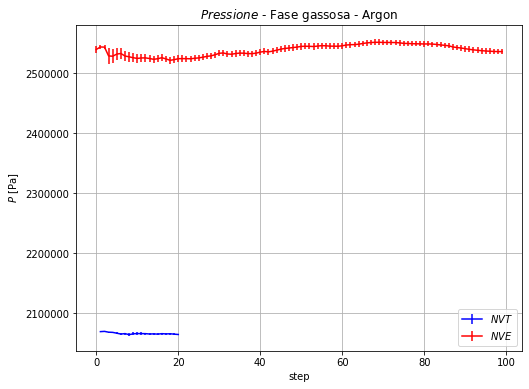

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [8, 6]
#SI units
eps_kb_arg = 120.0
sigma_arg = 0.34E-9
kb = 1.38E-23
eps_arg = eps_kb_arg * kb

step2_gas_NVT, pr_gas_NVT, err_pr_gas_NVT  = np.loadtxt("ex07.1/gas/output.pres.0", usecols=(0,2,3), unpack='true')
step2_gas_NVE, pr_gas_NVE, err_pr_gas_NVE = np.loadtxt("../ex4/ex04.1/risultati_gas/output_press_ave.dat", usecols=(0,1,2), unpack='true')

plt.errorbar(step2_gas_NVT, pr_gas_NVT*eps_arg/(sigma_arg**3), err_pr_gas_NVT*eps_arg/(sigma_arg**3), color='blue')
plt.errorbar(step2_gas_NVE, pr_gas_NVE*eps_arg/(sigma_arg**3), err_pr_gas_NVE*eps_arg/(sigma_arg**3), color='red')
plt.xlabel('step')
plt.ylabel('$P$ [Pa]')
plt.legend( ['$NVT$', '$NVE$'])
plt.grid(True)
plt.title("$Pressione$ - Fase gassosa - Argon")
plt.show()